In [1]:
import sys
from pathlib import Path

# Current working dir  …/DGRB Scripts/Test - sbi for 1 SFG and 1 mAGN…
# parent[0] → …/DGRB Scripts
# parent[1] → …/home/users/ids29           ← where “DGRB/” lives
package_path = Path.cwd().parents[1] / "DGRB"   # /home/users/ids29/DGRB

sys.path.insert(0, str(package_path))           # make it import-able


In [14]:
import sources.DMsignal as DMsignal
import numpy as np
from scipy.integrate import quad, simpson
import matplotlib.pyplot as plt

In [ ]:
# 1) Point to your data directory and choose a channel
data_dir = "../../DGRB/data/dm_spectra/"         # must contain AtProduction_gammas.dat
channel  = "Tau"                           # e.g. 'b' (bottom quarks) or 'Tau'


# 2) Build the DMsignal object
dm = DMsignal.DMsignal(directory=data_dir, channel=channel)

# ────────────────────────────────────────────────────────────────────────
# 3)  Ask the object for its default model parameters
#     (mass, amplitude, background).  These numbers come straight from
#     the get_default_model() method you showed.
# ────────────────────────────────────────────────────────────────────────
model_defaults = dm.get_default_model()        # {'A_DM': …, 'A_BG': …, 'mass_DM_MeV': …}
mass_DM_MeV    = model_defaults["mass_DM_MeV"]  # MeV
mass_DM_GeV    = mass_DM_MeV / 1e3                  # GeV
A_DM           = model_defaults["A_DM"] # unitless
A_BG           = model_defaults["A_BG"]






mass_DM_GeV: 200.0 GeV


In [4]:
energy_range = [1000, 100000] #MeV

Abundance function

In [32]:
def DM_abundance_fn(r, L, params):
    """
    Abundance function for the DM signal.
    """
    # r is the distance from the source # kpc
    # L is the luminosity of the source # photons/second
    # return the abundance function
    # params conatins 'mass of DM particle in GeV'

    mass_DM_GeV = params[2] # UPDAT TO THE CURRENT PARAMS INDEX

    
    beta = 1.9
    A = 1.2e4 # MSolar^{-1} kpc^{-3}
    r_s = 21 #kpc
    r_tilde = r / r_s # unitless
    cross_section = 3e-26 #cm^3 s^{−1}
    
    def compute_integral_E(E_min: float, E_max: float, n_points: int = 10_001) -> float:
        """
        Compute ∫ dN/dE dE between E_min and E_max [MeV]
        by sampling on a uniform grid and applying Simpson's rule.
        n_points must be odd for Simpson's rule.
        """
        # make sure we have an odd number of points
        if n_points % 2 == 0:
            n_points += 1

        E = np.linspace(E_min, E_max, n_points)
        dNdE = dm.get_dNdE(
            desired_E_MeV=E,
            channel=channel,
            mass_MeV= mass_DM_GeV * 1e3
        )
        return simpson(dNdE, E)

    Emin, Emax = energy_range[0], energy_range[1]
    integral_E = compute_integral_E(Emin, Emax)



    Phi_pp = A_DM * cross_section / (8 * np.pi * mass_DM_GeV**2) * integral_E  # cm^3 s^{-1} GeV^{-2}

    
    def integrand_M_tilde(M_tilde):
        sigma = 0.74 + 0.011 * np.log(r/50) - 0.003 * M_tilde / 0.87
        Delta = np.log(L) - 77.4 + 0.23*np.log(r/50) - np.log((8*np.pi*Phi_pp)/(1e-28)) # unitless
        mu = sigma**2 * (1-beta) / 0.87  +  Delta
        return np.exp((mu**2 -Delta**2)/(2*sigma**2)) * np.exp(-(M_tilde - mu)**2/(2*sigma**2)) / (np.sqrt(2*np.pi)*sigma)
    


    def compute_integral_M_tilde_simpson(M_min: float, M_max: float, n_points: int = 10001) -> float:
        """
        Integrate integrand_M_tilde from M_min to M_max using Simpson's rule.
        n_points must be odd; if it's even, it's incremented by 1.
        """
        if n_points % 2 == 0:
            n_points += 1
        M = np.linspace(M_min, M_max, n_points)
        y = integrand_M_tilde(M)
        return simpson(y, M)


    # Example usage:
    M_tilde_min = 0.87 * np.log(1/1e5) # M_min = 1 MSolar
    integral_M_tilde = compute_integral_M_tilde_simpson(M_tilde_min, 14.0) # The integrand 'integrand_M_tilde' is sufficiently suppressed for all M_tilde > 14.0



    
    return 10**(5*(1-beta)) * A / (0.87 * L * r_tilde * (1+r_tilde)**2)   * integral_M_tilde


def DM_spectrum(energy, params): #'energy' is an array of energies in MeV 
    return dm.get_dNdE(
            desired_E_MeV=energy,
            channel=channel,
            mass_MeV= mass_DM_GeV * 1e3
        )

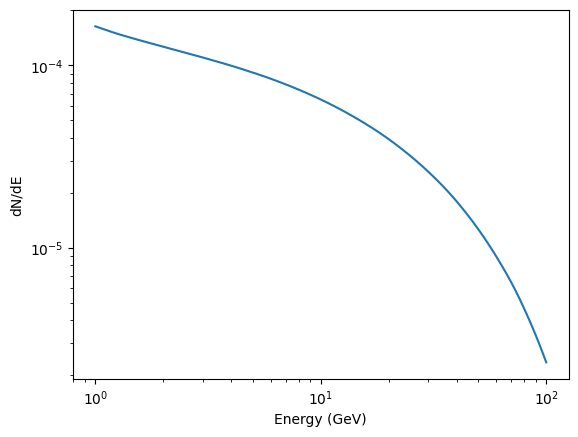

In [34]:
energies = np.linspace(energy_range[0], energy_range[1], 1000) # MeV
plt.loglog(energies/1e3, DM_spectrum(energies, np.array([0, 0, 1])))
plt.xlabel("Energy (GeV)")
plt.ylabel("dN/dE")
plt.show()

Spectrum

In [ ]:


# ────────────────────────────────────────────────────────────────────────
# 4)  Wrapper: E [MeV] → dN/dE [photons / MeV per annihilation]
# ────────────────────────────────────────────────────────────────────────
def dm_spectrum(E_MeV: np.ndarray | float) -> np.ndarray:
    """
    Interpolated gamma-ray spectrum for the chosen DM channel,
    using the default mass encoded in DMsignal.py.
    """
    return dm.get_dNdE(
        desired_E_MeV=np.asarray(E_MeV, dtype=float),
        channel=channel,
        mass_MeV=mass_DM_MeV,          # picked up from get_default_model()
    )
